In [128]:
import matplotlib.pyplot as plt
from torch.utils import data
import numpy as np
from tqdm import tqdm
import random
from visualisationMetrics import *
from dataLoader import *
from utils.utils import plot_2axes
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from collections import defaultdict

In [467]:
LOGDIR_NAME = 'var'

### Step 1: Load real data

In [129]:
real_data = load_dataset(data_mode='Train')
real_dataloader = data.DataLoader(real_data, batch_size=1, num_workers=1, shuffle=True)
print(f"gen ~ N({real_data.Y.mean()}, {real_data.Y_test.var(axis=-1).mean()})")

[*********************100%%**********************]  1 of 1 completed


X_train's shape is (4328, 1, 1, 2), X_test's shape is (481, 1, 1, 2)
y_train's label shape is (4328, 1, 1, 43), y_test's label shape is (481, 1, 1, 43)
gen ~ N(1.0090950727462769, 0.0008807111880742013)


In [130]:
real_paths = []
real_conds = []

for i, (cond, sim) in enumerate(real_dataloader):
    sim = sim.cpu().detach().numpy()
    sim = sim.reshape(sim.shape[1], sim.shape[3])
    real_paths.append(sim)
    cond = cond.cpu().detach().numpy()
    cond = cond.reshape(cond.shape[1], cond.shape[3])
    real_conds.append(cond)

real_paths = np.array(real_paths)
real_conds = np.array(real_conds)
print(real_paths.shape)
print(real_conds.shape)

(481, 1, 43)
(481, 1, 2)


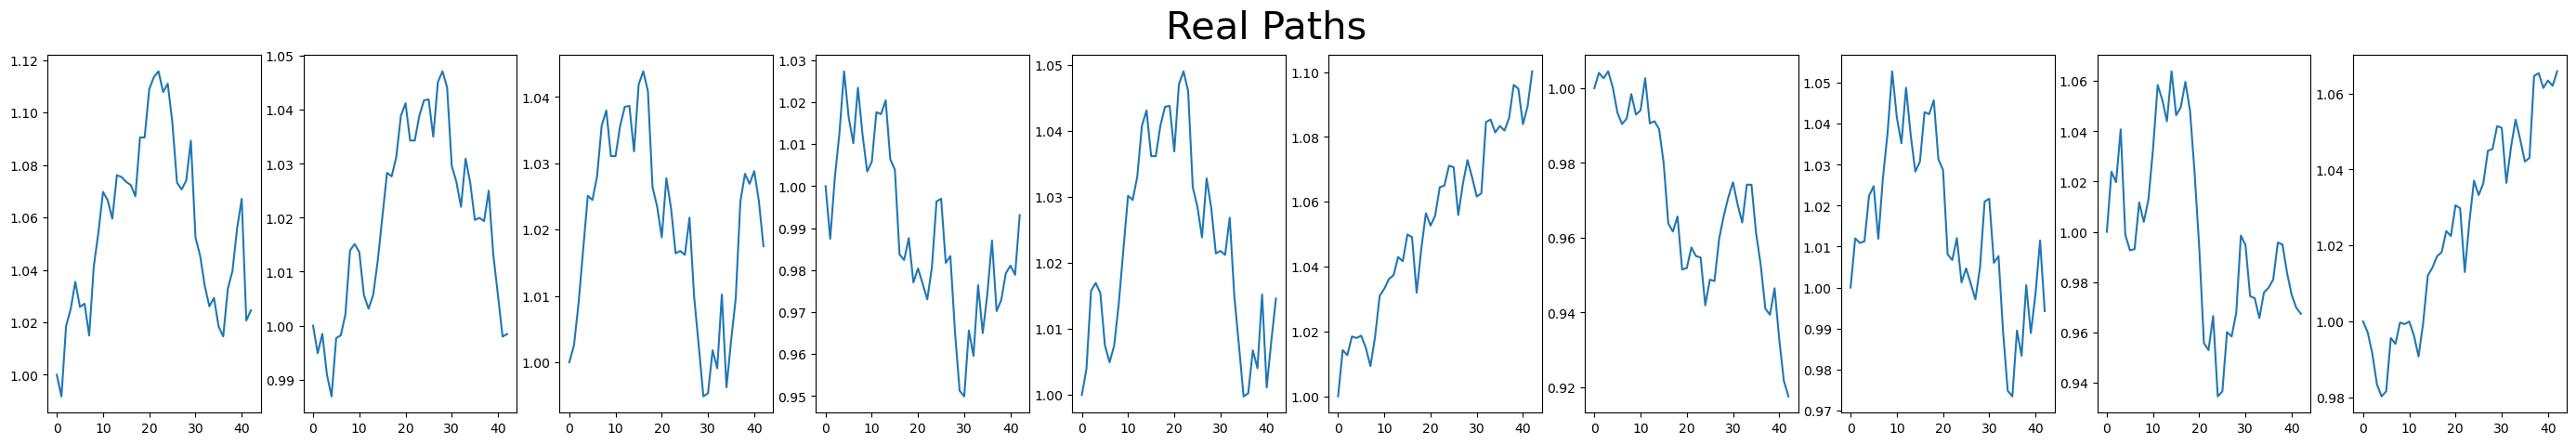

In [131]:
fig, axs = plt.subplots(1, 10, figsize=(35,5))
fig.suptitle('Real Paths', fontsize=30)
for i in range(10):
    for path in real_paths[i]:
        axs[i].plot(path[:])

### Step 2: Load synthetic data

In [468]:
from LoadSynthetic import *

In [469]:
syn_data = Synthetic_Dataset(model_path=f'./logs/{LOGDIR_NAME}/Model/checkpoint', n=10, dataset=real_data, seq_len=real_data.output_size, conditions_dim=real_data.X_train.shape[-1])
syn_dataloader = data.DataLoader(syn_data, batch_size=1, num_workers=1, shuffle=True)

In [470]:
syn_paths = []
syn_conds = []

for i, (cond, sim) in enumerate(syn_dataloader):
    sim = sim.cpu().detach().numpy()
    sim = sim.reshape(sim.shape[1], sim.shape[3])
    syn_paths.append(sim)
    cond = cond.cpu().detach().numpy()
    cond = cond.reshape(cond.shape[1], cond.shape[3])
    syn_conds.append(cond)
    
syn_paths = np.array(syn_paths)
syn_conds = np.array(syn_conds)
print(syn_paths.shape)
print(syn_conds.shape)

(4810, 1, 43)
(4810, 1, 2)


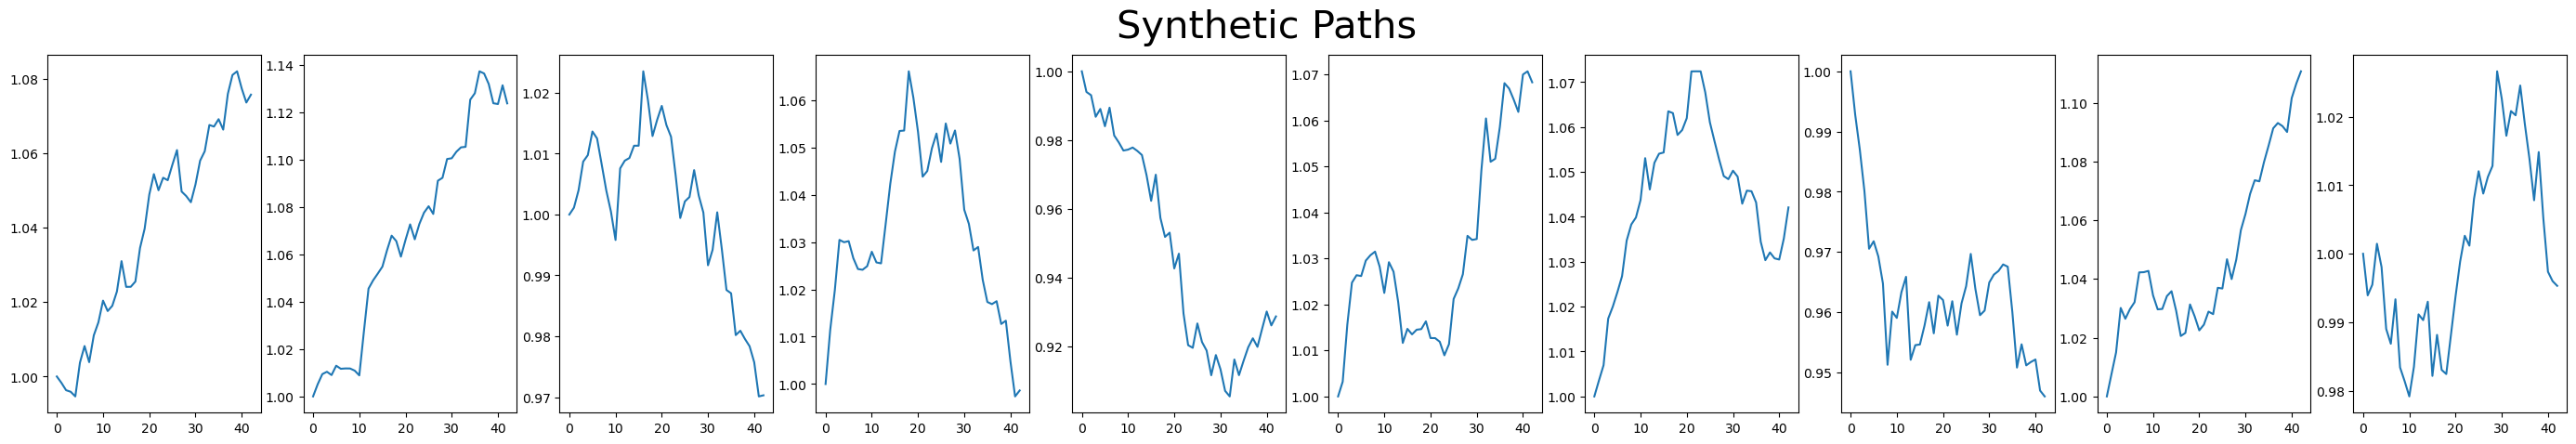

In [471]:
np.random.shuffle(syn_paths)
fig, axs = plt.subplots(1, 10, figsize=(35,5))
fig.suptitle('Synthetic Paths', fontsize=30)
for i in range(10):
    for path in syn_paths[i]:
        axs[i].plot(path[:])

### Step 3: Load benchmark data

In [472]:
from utils.utils import GBM_Simulator

In [473]:
simulator = GBM_Simulator(dataset=real_data)
gbm_paths = simulator.run()
gbm_paths = np.reshape(gbm_paths, (-1,1,gbm_paths.shape[-1]))

print(gbm_paths.shape)

  0%|          | 0/480 [00:00<?, ?it/s]

100%|██████████| 480/480 [00:00<00:00, 928.36it/s]

(4810, 1, 43)


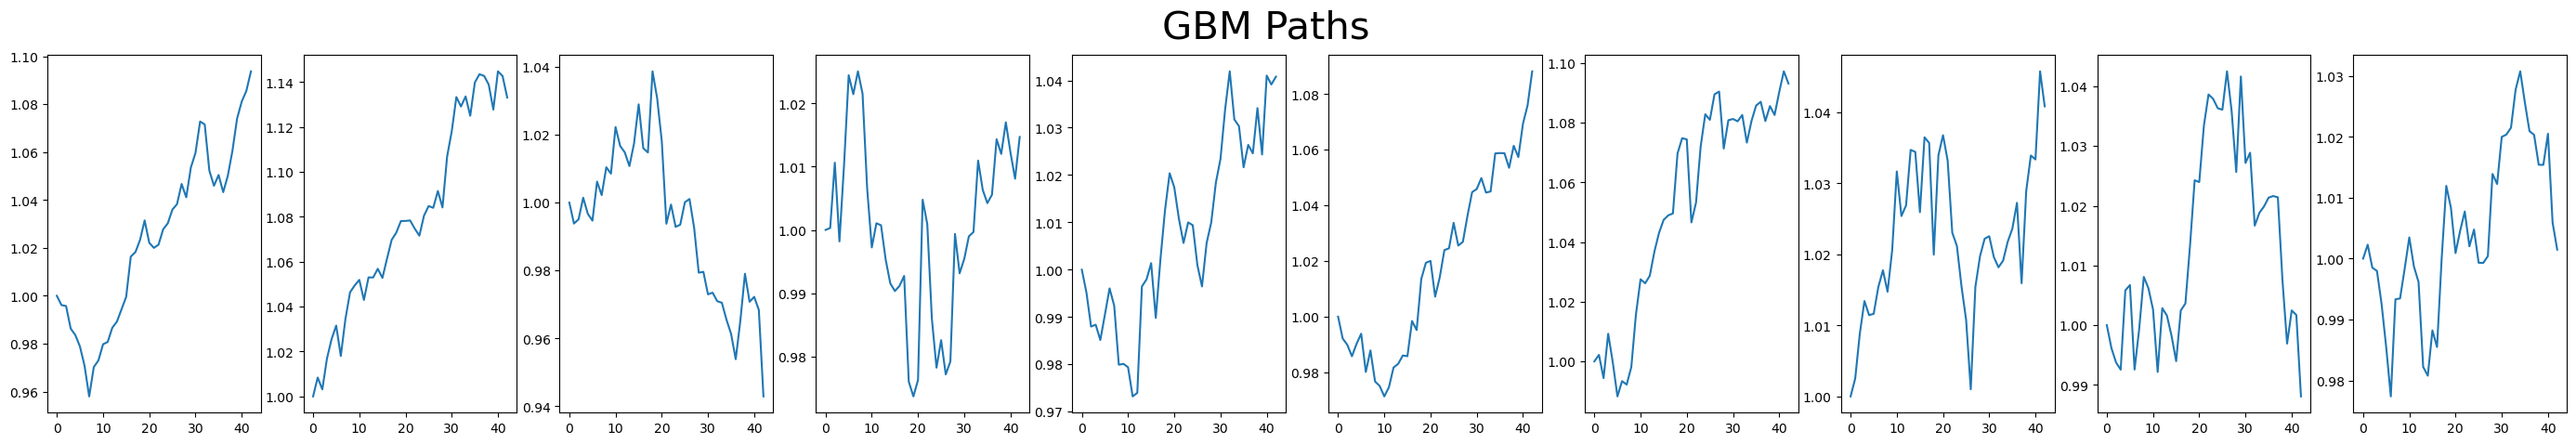

In [474]:
fig, axs = plt.subplots(1, 10, figsize=(35,5))
fig.suptitle('GBM Paths', fontsize=30)
samples = random.sample(range(len(gbm_paths)),k=10)
for i in range(10):
    for sim in gbm_paths[samples[i]]:
        axs[i].plot(sim[:])

### Dimensionality Reduction

In [475]:
real_vals = np.transpose(real_paths, (0,2,1)) #np.concatenate((real_conds, real_paths), axis=-1), (0,2,1))
syn_vals = np.transpose(syn_paths, (0,2,1)) #np.concatenate((syn_conds, syn_paths), axis=-1), (0,2,1))
np.random.shuffle(syn_vals)
gbm_vals = np.transpose(gbm_paths, (0, 2, 1))
np.random.shuffle(gbm_vals)

print(real_vals.shape)
print(syn_vals.shape)
print(gbm_vals.shape)

(481, 43, 1)
(4810, 43, 1)
(4810, 43, 1)


In [476]:
visualization([real_vals, syn_vals, gbm_vals], ['Real', 'Synthetic', 'Benchmark (GBM)'], 'pca', 'test')

In [477]:
visualization([real_vals, syn_vals, gbm_vals], ['Real', 'Synthetic', 'Benchmark (GBM)'], 'tsne', 'test')

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1443 samples in 0.000s...
[t-SNE] Computed neighbors for 1443 samples in 0.153s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1443
[t-SNE] Computed conditional probabilities for sample 1443 / 1443
[t-SNE] Mean sigma: 0.046254
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.190746
[t-SNE] KL divergence after 300 iterations: 1.169704


### Compute JS divergence

In [478]:
from utils.utils import js_divergence

In [479]:
print(real_vals.min(), real_vals.max())
print(syn_vals.min(), syn_vals.max())
print(gbm_vals.min(), gbm_vals.max())

0.82385856 1.1770248
0.83247143 1.2149843
0.0 1.2568733588546892


In [480]:
n_components = 10
real_pca, syn_pca, gbm_pca = dim_reduction([real_vals, syn_vals, gbm_vals], n_components=n_components, mode='pca')
real_tsne, syn_tsne, gbm_tsne = dim_reduction([real_vals, syn_vals, gbm_vals], n_components=n_components, mode='tsne')

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1443 samples in 0.001s...
[t-SNE] Computed neighbors for 1443 samples in 0.129s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1443
[t-SNE] Computed conditional probabilities for sample 1443 / 1443
[t-SNE] Mean sigma: 0.046254
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.190781
[t-SNE] KL divergence after 300 iterations: 1.169676


In [481]:
divergence = js_divergence(real_pca, syn_pca)
print(divergence)
divergence = js_divergence(real_pca, gbm_pca)
print(divergence)

print()

divergence = js_divergence(real_tsne, syn_tsne)
print(divergence)
divergence = js_divergence(real_tsne, gbm_tsne)
print(divergence)

KL(data1||data2) = 1.8842967822109935
KL(data2||data1) = 1.0185017256392546
1.451399253925124
KL(data1||data2) = 3.8025655988159044
KL(data2||data1) = 1.2657388981656397
2.534152248490772

KL(data1||data2) = 0.10667202295088818
KL(data2||data1) = 0.08436893950084727
0.09552048122586773
KL(data1||data2) = 0.4946962685174612
KL(data2||data1) = 0.20044094215897412
0.34756860533821765


### Compute FID score

In [482]:
from utils.utils import fid

In [483]:
print(fid(real_vals, syn_vals))
print(fid(real_vals, gbm_vals))

0.004770666631256043
0.01328687709955113


### Simulate given conditions

In [484]:
df = real_data.df
simulator = GBM_Simulator(dataset=real_data)

def generate_paths(date, n=500, mode='syn'):
    paths = None
    if mode=='syn':
        paths = syn_data.get_sims(date, n=n)
        paths = np.array(paths).reshape(paths.shape[0], paths.shape[-1])
    elif mode=='gbm':
        paths = simulator.get_sims(date, n=n)
    else:
        raise NotImplementedError
    paths = paths * df.loc[date]['close']
    return paths

def plot_sims(dates, mode, n=50, error_bars=True, output_size=real_data.output_size):
    assert output_size <= real_data.output_size
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    info = defaultdict(list)
    for date in dates:
        syn_paths = generate_paths(date, n=n, mode=mode)[:,:output_size]
        sim_dates = df.loc[date:].index[:output_size]
        if len(sim_dates)<syn_paths.shape[-1]:
            sim_dates = pd.date_range(date, periods=output_size+1, freq='B')
        for i, path in enumerate(syn_paths):
            fig.add_trace(go.Scatter(
                x=sim_dates, y=path,
                mode='lines',
                name=f'{date} simulations',
                legendgroup=f'simulations',
                showlegend=i==0,
            ), secondary_y=True,)
        info['s0'].append(syn_paths[0,0])
        info['start_dates'].append(sim_dates[0])
        info['end_dates'].append(sim_dates[-1])
        info['means'].append(syn_paths[:,-1].mean())
        info['stds'].append(syn_paths[:,-1].std(ddof=1))

    # Plot mean & std
    if error_bars:
        fig.add_trace(go.Scatter(
            x=info['end_dates'],
            y=info['means'],
            mode='markers',
            error_y=dict(
                type='data',
                array=info['stds'],
                visible=True
            ),
            line=dict(color="Brown"),
            showlegend=False,
        ), secondary_y=True,)
        fig.add_trace(go.Scatter(
            x=info['start_dates'],
            y=info['s0'],
            mode='markers',
            line=dict(color="Brown"),
            showlegend=False,
        ), secondary_y=True,)
        for i in range(len(dates)):
            fig.add_trace(go.Scatter(
                x=[info['start_dates'][i], info['end_dates'][i]],
                y=[info['s0'][i], info['means'][i]],
                mode='lines',
                line=dict(color="Brown"),
                showlegend=False,
            ), secondary_y=True,)
            
    fig.add_trace(
        go.Scatter(x=df.index, y=df['close'], name='close', line=dict(color="Black")),
        secondary_y=True,
    )
    fig.add_trace(
        go.Scatter(x=df.index, y=df['ivol'], name='ivol', line=dict(color="Gray")),
        secondary_y=False, 
    )

    fig.add_vline(x=real_data.test_start_date, line_dash="dash")
    fig.add_annotation(x=real_data.test_start_date, y=10, text='Test start date', showarrow=False)

    # Set y-axes titles
    fig.update_yaxes(title_text='ivol', secondary_y=False)
    fig.update_yaxes(title_text='close', secondary_y=True)
    fig.show()

In [485]:
dates = df.loc[real_data.test_start_date:].index
dates = dates[(np.array(range(len(dates))))%10==0]
n = 10

In [486]:
plot_sims(dates, mode='syn', n=n)

In [487]:
plot_sims(dates, mode='gbm', n=n)

### Runtime

In [488]:
for i in tqdm(range(100)):
    _ = generate_paths('2022-03-07', n=100, mode='syn').shape

100%|██████████| 100/100 [00:03<00:00, 28.89it/s]


In [489]:
for i in tqdm(range(100)):
    _ = generate_paths('2022-03-07', n=100, mode='gbm').shape

100%|██████████| 100/100 [00:00<00:00, 172.98it/s]
